# Various data summary statistics

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn
import pandas as pd
from tqdm.notebook import tqdm
from pprint import pprint
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import ttest_ind, f_oneway
from pprint import pprint
import pydicom
from collections import Counter
import scipy
import yaml

## 1. Load metadata and data list

In [2]:
with open("/blinded.pkl", "rb") as f:
    metadata = pickle.load(f)

In [3]:
with open("/blinded.pkl", "rb") as f:
    datalist = pickle.load(f)

In [4]:
train_acns = list(datalist[0].keys())
val_acns = list(datalist[1].keys())
test_acns = list(datalist[2].keys())

In [5]:
all_datalist_acns = list(datalist[0].keys()) + list(datalist[1].keys()) + list(datalist[2].keys())

In [6]:
subgroups = pd.read_pickle("/blinded.pkl")
ethnicity = pd.read_csv("/blinded.csv")

In [7]:
# Convert MRN-keyed dict to ACN-keyed dict
metadata_acn = {}
for mrn, patient in metadata.items():
    for study in patient['ExamsInfo']:
        acn = study['AccessionNumber'].strip()
        metadata_acn[acn] = study
metadata_acn_df = pd.DataFrame.from_dict(metadata_acn, orient='index')

## 2. Age distributions

In [11]:
master_ages = []
all_ages = []
for split_name, split in zip(['train', 'val', 'test'], [datalist[0], datalist[1], datalist[2]]):
    for acn in split.keys():
        meta = metadata_acn[str(acn)]
        age = meta['PatientAge']
        if len(age) == 4:
            calc_age = int(age[:3])
        else:
            # Missing / non-standard format
            study_date = datetime.strptime(meta['StudyDate'], '%Y%m%d').date()
            patient_birth_date = datetime.strptime(meta['PatientBirthDate'], '%Y%m%d').date()
            calc_age = relativedelta(study_date, patient_birth_date).years
        master_ages.append((split_name, calc_age))
        all_ages.append(calc_age)

# The data frame below contains pairs split--age for all cases in the datalist:
df = pd.DataFrame.from_records(master_ages, columns=['split', 'age'])

# Print general info
print("Patient age at the time of the exam ranged from {} to {}, with a mean of {} (SD {})".format(
    np.min(all_ages),
    np.max(all_ages),
    np.mean(all_ages),
    np.std(all_ages)
))

Patient age at the time of the exam ranged from 15 to 98, with a mean of 54.84398941356735 (SD 12.569276488596838)


### 2.1. Age distributions - normality and differences between groups

In [21]:
# Tests for mean equality of multiple distributions
kruskal_equal_means = scipy.stats.kruskal(
    [t[1] for t in master_ages if t[0] == 'train'],
    [t[1] for t in master_ages if t[0] == 'val'],
    [t[1] for t in master_ages if t[0] == 'test']
)
anova_equal_means = f_oneway(
    [t[1] for t in master_ages if t[0] == 'train'],
    [t[1] for t in master_ages if t[0] == 'val'],
    [t[1] for t in master_ages if t[0] == 'test']
)

if anova_equal_means.pvalue < 0.05:
    print(f"ANOVA suggests that means of subsets are NOT equal (p={anova_equal_means.pvalue})")
else:
    print(f"ANOVA suggests that means of subsets are equal  (p={anova_equal_means.pvalue})")

if anova_equal_means.pvalue < 0.05:
    print(f"Kruskal-Wallis H test suggests that medians of subsets are NOT equal (p={kruskal_equal_means.pvalue})")
else:
    print(f"Kruskal-Wallis H test suggests that medians of subsets are equal (p={kruskal_equal_means.pvalue})")

ANOVA suggests that means of subsets are NOT equal (p=0.0116233654976698)
Kruskal-Wallis H test suggests that medians of subsets are NOT equal (p=0.008981100040198172)


### 2.2. Age distributions - plot histogram

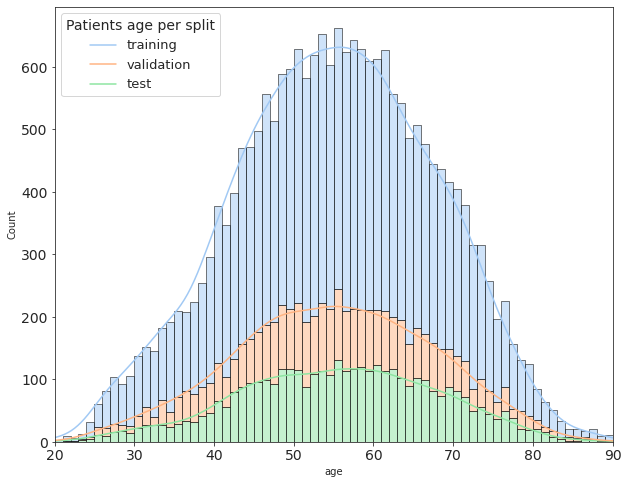

In [22]:
plt.figure(figsize=(10,8))
seaborn.set_style('ticks')

seaborn.histplot(
    df, x="age", hue="split", multiple="stack", bins=np.arange(0,100), palette=seaborn.color_palette("pastel", 3), kde=True, fill=True, edgecolor="black"
)

plt.xlim(20, 90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
a = Line2D([], [], color=seaborn.color_palette("pastel", 3)[0], label='la')
b = Line2D([], [], color=seaborn.color_palette("pastel", 3)[1], label='lb')
c = Line2D([], [], color=seaborn.color_palette("pastel", 3)[2], label='lc')
plt.legend(title='Patients age per split', loc='upper left', labels=['training', 'validation', 'test'], handles=[a, b, c], fontsize=13, title_fontsize=14)

#plt.savefig('mri_datareport_age.png')

# 3. Machines

### 3.1. Machines - NYU Langone dataset

In [24]:
with open("/blinded.pkl", "rb") as f:
    metadata_part1 = pickle.load(f)
with open("/blinded.pkl", "rb") as f:
    metadata_part2 = pickle.load(f)

machine_metadata_all = {**metadata_part1, **metadata_part2}  # Combine two dicts

In [25]:
with open("/blinded.pkl", "rb") as f:
    metadata_c = pickle.load(f)

In [31]:
metadata_holder = {
    'AccessionNumber': [],
    'Modality': [],
    'ModalitiesInStudy': [],
    'Manufacturer': [],
    'ManufacturerModelName': [],
    'InstitutionName': [],
    'StationName': [],
    'BodyPartExamined': [],
    'PregnancyStatus': [],
    'ManufacturerFull': [],
    'CodeMeaning': [],
    'ImageComments': [],
    'StudyComments': [],
    'StudyDescription': []
}

def debugging_checks(acn, k, v):
    if k == 'Manufacturer' and v=='LIVER':
        print(acn)

for acn, study_meta in tqdm(machine_metadata_all.items(), total=len(machine_metadata_all)):
    if acn in all_datalist_acns:
        for k, v in study_meta.items():
            if k in metadata_holder:
                metadata_holder[k].append(v)
                debugging_checks(acn, k, v)
            else:
                print(f"{k} not found")
        metadata_holder['ManufacturerFull'].append(study_meta['Manufacturer'] + " " + study_meta['ManufacturerModelName'])
        if 'CodeMeaning' not in study_meta:
            metadata_holder['CodeMeaning'].append("?")
        #metadata_holder['AccessionNumber'].append(acn)

  0%|          | 0/29012 [00:00<?, ?it/s]

In [32]:
# Convert dict to the data frame for nice view
machine_df = pd.DataFrame.from_dict(metadata_holder)

In [ ]:
manu = {
    "siemens": 0,
    "philips": 0,
    "ge": 0,
    "hitachi": 0,
    "unknown": 0,
}
for m in machine_df.ManufacturerFull:
    if "siemens" in m.lower():
        manu['siemens'] += 1
    elif 'pacs' in m.lower():
        manu['unknown'] += 1
    elif "philips" in m.lower():
        manu['philips'] += 1
    elif 'ge' in m.lower():
        manu['ge'] += 1
    elif 'hitachi' in m.lower():
        manu['hitachi'] += 1
    else:
        manu['unknown'] += 1
pprint(manu)

##### Add machine info to subgroup file

In [358]:
subgroups = subgroups.merge(machine_df[['AccessionNumber', 'Manufacturer', 'ManufacturerFull']], how='left', left_on='Acc', right_on='AccessionNumber')

### 3.2. Machines - Duke dataset

In [54]:
with open("/blinded.pkl", "rb") as f:
    duke_datalist = pickle.load(f)

In [99]:
duke_ids_included = list(duke_datalist[2].keys())  # List of Duke Dataset IDs that we actually included in our dataset (910)

In [63]:
duke_df = pd.read_excel("/Clinical_and_Other_Features.xlsx", header=1)
duke_df = duke_df[1:]

In [90]:
def get_manufacturer_name(row):
    manufacturer = {
        0: "GE",
        1: "MPTronic software",
        2: "SIEMENS"
    }
    model = {
        0: "Avanto",
        1: "Optima MR450w",
        2: "SIGNA EXCITE",
        3: "SIGNA HDx",
        4: "SIGNA HDxt",
        5: "Skyra",
        6: "Trio",
        7: "TrioTim"
    }
    full_name = (manufacturer[row.Manufacturer] + " " + model[row['Manufacturer Model Name']])
    return full_name

In [91]:
duke_df['manufacturer_full_name'] = duke_df.apply(get_manufacturer_name, axis=1)

### 3.3. Machines - TCGA-BRCA dataset

In [145]:
with open("/blinded.pkl", "rb") as f:
    tcga_datalist = pickle.load(f)
with open("tcga_brca_key.yaml", "r") as f:
    pre_post_dict = yaml.safe_load(f)

In [110]:
tcga_ids_included = list(tcga_datalist[2].keys())

In [ ]:
tcga_basedir = "/MRI-TCIA-BRCA-Dataset/TCGA-BRCA"
c = 0
df_tcga_machines = pd.DataFrame(columns=['id', 'manufacturer', 'model', 'full'])
for patient_dirname in tqdm(os.listdir(tcga_basedir)):
    patient_dir = os.path.join(tcga_basedir, patient_dirname)
    for study_dirname in os.listdir(patient_dir):
        study_dir = os.path.join(patient_dir, study_dirname)
        full_id = f"{patient_dirname}___{study_dirname.replace(' ', '_')}"
        if full_id in tcga_ids_included:
            c += 1
            relevant_series_num = list(pre_post_dict['subjects'][patient_dirname]['studies'][study_dirname]['series'].keys())[0]
            
            series_names = os.listdir(study_dir)
            # take a single relevant series and open a single dicom file
            for s in series_names:
                if s.startswith(f"{str(relevant_series_num)}."):
                    serie_dir = os.path.join(study_dir, s)
                    first_dicom = os.path.join(serie_dir, os.listdir(serie_dir)[0])
                    ds = pydicom.dcmread(first_dicom)
                    # get manufacturer info
                    df_tcga_machines = df_tcga_machines.append({
                        'id': full_id,
                        'manufacturer': ds.Manufacturer,
                        'model': ds.ManufacturerModelName,
                        'full': f"{ds.Manufacturer} {ds.ManufacturerModelName}"
                    }, ignore_index=True)
                    break
            
print(f"There are {c} TCGA-BRCA studies in our dataset")

### 3.4. Machines - Jagiellonian University dataset

In [166]:
with open("/blinded.pkl", "rb") as f:
    uj_datalist = pickle.load(f)

In [ ]:
df_uj_machines = pd.DataFrame(columns=['id', 'manufacturer', 'model', 'full'])
for full_id in tqdm(list(uj_datalist[2].keys())):
    id_split = full_id.split(")_")
    patient_id = f"{id_split[0]})"
    study_id = id_split[1]
    try:
        if 'malignant' in patient_id:
            subdir = "malignant_cases"
        else:
            subdir = "benign_cases"
        
        study_path = os.path.join("/blinded/", subdir, patient_id, study_id)

        # take random dicom
        ds = pydicom.dcmread(os.path.join(study_path, os.listdir(study_path)[0]))
        df_uj_machines = df_uj_machines.append({
            'id': full_id,
            'manufacturer': ds.Manufacturer,
            'model': ds.ManufacturerModelName,
            'full': f"{ds.Manufacturer} {ds.ManufacturerModelName}"
        }, ignore_index=True)
    except Exception as e:
        print(f"Not found for {full_id}: {e}")

# 4. Patient breakdown table

In [31]:
asian_races = [] #blinded
unknown_races = [np.nan, 'Unknown', 'Other Race', 'Patient Refused']

##### Merge subgroups DF with metadata

In [32]:
metadata_only_used = metadata_acn_df.reset_index().rename({"index": "acn"}, axis='columns')
metadata_only_used = metadata_only_used[metadata_only_used.acn.isin(all_datalist_acns)][["acn", "PatientID", "PatientBirthDate", "StudyDate", "PatientAge", "PatientWeight"]]
metadata_only_used = metadata_only_used.merge(
    subgroups[['Acc', 'bpe', 'birads', 'AgeFix', 'NME', 'foci', 'histology', 'her2', 'er', 'pr', 'ki67', 'molecular_status', 'left_benign', 'left_malignant', 'right_benign', 'right_malignant', 'ethnicity', 'firstrace', 'indication', 'implant_bilateral', 'implant', 'birads_granular', 'Manufacturer', 'mammographic_density', 'fibroglandular_tissue']],
    how='left', 
    left_on='acn', 
    right_on='Acc'
)

In [33]:
metadata_only_used_train = metadata_only_used[metadata_only_used.acn.isin(train_acns)]
metadata_only_used_val = metadata_only_used[metadata_only_used.acn.isin(val_acns)]
metadata_only_used_test = metadata_only_used[metadata_only_used.acn.isin(test_acns)]

In [34]:
metadata_only_used['any_label'] = metadata_only_used[['left_benign', 'left_malignant', 'right_benign', 'right_malignant']].max(axis=1)
metadata_only_used['any_malignant'] = metadata_only_used[['left_malignant', 'right_malignant']].max(axis=1)
metadata_only_used['any_benign'] = metadata_only_used[['left_benign', 'right_benign']].max(axis=1)

In [35]:
metadata_only_used['any_benign_malignant'] = np.where(
    metadata_only_used['any_malignant'] == 1,
        np.where(
            metadata_only_used['any_benign'] == 1,
            1,
            0
        ),
        0
)

In [40]:
table_dict = {}
for subdf, split_name in zip([metadata_only_used_train, metadata_only_used_val, metadata_only_used_test, metadata_only_used], ["train", "val", "test", "total"]):
    # Keep longer filters here:
    subdf_malignant = subdf[(subdf.left_malignant==1) | (subdf.right_malignant==1)]
    subdf_benign = subdf[(subdf.left_benign==1) | (subdf.right_benign==1)]
    subdf_negative = subdf[(subdf.left_malignant==0) & (subdf.right_malignant==0) & (subdf.left_benign==0) & (subdf.right_benign==0)]
    
    subdf_unknown_birads = subdf[subdf.birads.isin(['NO VALID BI-RADS', 'TOO MANY BI-RADS'])]
    
    subdf_bpe_a_b = subdf[subdf.bpe.isin(["minimal", "mild"])]
    subdf_bpe_c_d = subdf[subdf.bpe.isin(["moderate", "marked"])]
    subdf_bpe_unknown = subdf[subdf.bpe.isin(["TOO MANY", "NOT FOUND", np.nan])]
    
    # Create a table
    table_dict[split_name] = {
        "Studies": f"{len(subdf):,}",
        "Patients": f"{len(subdf.PatientID.unique()):,}",
        
        "\textbf{Age}": "",
        "$\quad$ mean years (SD)": f"{subdf.AgeFix.mean():.2f}$\pm${subdf.AgeFix.std():.1f}",  # mean (SD)
        "$\quad$ under 40": f"{len(subdf[subdf.AgeFix<40]):,} ({len(subdf[subdf.AgeFix<40])/len(subdf)*100:.1f})",  # N (%)
        
        "\textbf{Race}": "",
        "$\quad$ White": f"{len(subdf[subdf.firstrace=='White']):,} ({len(subdf[subdf.firstrace=='White'])/len(subdf)*100:.1f})",
        "$\quad$ Black": f"{len(subdf[subdf.firstrace=='African American (Black)']):,} ({len(subdf[subdf.firstrace=='African American (Black)'])/len(subdf)*100:.1f})",
        "$\quad$ Asian": f"{len(subdf[subdf.firstrace.isin(asian_races)]):,} ({len(subdf[subdf.firstrace.isin(asian_races)])/len(subdf)*100:.1f})",        
        "$\quad$ Other/Unknown": f"{len(subdf[~subdf.firstrace.isin(['White', 'African American (Black)'] + asian_races)]):,} ({len(subdf[~subdf.firstrace.isin(['White', 'African American (Black)'] + asian_races)])/len(subdf)*100:.1f})",
        
        "\textbf{Label}": "",
        "$\quad$ Malignant": f"{len(subdf_malignant):,} ({len(subdf_malignant)/len(subdf)*100:.1f})",
        "$\quad$ Benign": f"{len(subdf_benign):,} ({len(subdf_benign)/len(subdf)*100:.1f})",
        "$\quad$ Negative": f"{len(subdf_negative):,} ({len(subdf_negative)/len(subdf)*100:.1f})",
        
        "\textbf{BI-RADS category}": "",
        "$\quad$ BI-RADS 0": f"{len(subdf[subdf.birads==0]):,} ({len(subdf[subdf.birads==0])/len(subdf)*100:.1f})",
        "$\quad$ BI-RADS 1": f"{len(subdf[subdf.birads==1]):,} ({len(subdf[subdf.birads==1])/len(subdf)*100:.1f})",
        "$\quad$ BI-RADS 2": f"{len(subdf[subdf.birads==2]):,} ({len(subdf[subdf.birads==2])/len(subdf)*100:.1f})",
        "$\quad$ BI-RADS 3": f"{len(subdf[subdf.birads==3]):,} ({len(subdf[subdf.birads==3])/len(subdf)*100:.1f})",
        "$\quad$ BI-RADS 4": f"{len(subdf[subdf.birads==4]):,} ({len(subdf[subdf.birads==4])/len(subdf)*100:.1f})",
        "$\quad$ BI-RADS 5": f"{len(subdf[subdf.birads==5]):,} ({len(subdf[subdf.birads==5])/len(subdf)*100:.1f})",
        "$\quad$ BI-RADS 6": f"{len(subdf[subdf.birads==6]):,} ({len(subdf[subdf.birads==6])/len(subdf)*100:.1f})",
        "$\quad$ BI-RADS unknown": f"{len(subdf_unknown_birads):,} ({len(subdf_unknown_birads)/len(subdf)*100:.1f})",
        
        "\textbf{BPE category}": "",
        "$\quad$ BPE a-b": f"{len(subdf_bpe_a_b):,} ({len(subdf_bpe_a_b)/len(subdf)*100:.1f})",
        "$\quad$ BPE c-d": f"{len(subdf_bpe_c_d):,} ({len(subdf_bpe_c_d)/len(subdf)*100:.1f})",
        "$\quad$ BPE unknown": f"{len(subdf_bpe_unknown):,} ({len(subdf_bpe_unknown)/len(subdf)*100:.1f})",
        
        "\textbf{Fibroglandular tissue (FGT)}": "",
        "$\quad$ A/B (Fatty/scattered)": f"{len(subdf[subdf.fibroglandular_tissue.isin([1,2])]):,} ({len(subdf[subdf.fibroglandular_tissue.isin([1,2])])/len(subdf)*100:.1f})",
        "$\quad$ C/D (Heterogeneous/extreme)": f"{len(subdf[subdf.fibroglandular_tissue.isin([3,4])]):,} ({len(subdf[subdf.fibroglandular_tissue.isin([3,4])])/len(subdf)*100:.1f})",
        "$\quad$ Unknown FGT status": f"{len(subdf[subdf.fibroglandular_tissue.isin(['NOT FOUND', 'TOO MANY', np.nan])]):,} ({len(subdf[subdf.fibroglandular_tissue.isin(['NOT FOUND', 'TOO MANY', np.nan])])/len(subdf)*100:.1f})",
    }

# 5. Histological and molecular types

In [417]:
# Histological subtypes
table_dict = {}
for subdf, split_name in zip([metadata_only_used_train, metadata_only_used_val, metadata_only_used_test, metadata_only_used], ["train", "val", "test", "total"]):
    hist = {
        "Invasive carcinoma of no special type": len(subdf[subdf.histology.apply(lambda x: 'IDC' in str(x))]),
        "Invasive lobular carcinoma": len(subdf[subdf.histology.apply(lambda x: 'ILC' in str(x))]),
        "Ductal carcinoma in situ": len(subdf[subdf.histology.apply(lambda x: 'DCIS' in str(x))]),
        "Metastatic carcinoma": len(subdf[subdf.histology.apply(lambda x: 'meta' in str(x))]),
        "Invasive mammary carcinoma": len(subdf[subdf.histology.apply(lambda x: 'IMC' in str(x))]),
        "Adenocarcinoma": len(subdf[subdf.histology.apply(lambda x: 'adenocarcinoma' in str(x))]),
        "Papillary carcinoma": len(subdf[subdf.histology.apply(lambda x: 'papillary carcinoma' in str(x))]),
        "Lymphoma (B-cell/lymphocytic)": len(subdf[subdf.histology.apply(lambda x: any(y in str(x) for y in ['lymphocytic lymphoma', 'b-cell lymphoma']))]),
        "Other/Unknown": len(subdf[subdf.histology.apply(lambda x: 'unknown' in str(x))]),
    }
    table_dict[split_name] = hist

In [429]:
# Molecular subtypes
table_dict = {}
for subdf, split_name in zip([metadata_only_used_train, metadata_only_used_val, metadata_only_used_test, metadata_only_used], ["train", "val", "test", "total"]):
    hist = subdf.molecular_status.value_counts().to_dict()

    hist = {"Luminal A" if k == 'luminalA' else k:v for k,v in hist.items()}
    hist = {"Luminal B" if k == 'luminalB' else k:v for k,v in hist.items()}
    hist = {"Luminal unknown" if k == 'luminalUnknown' else k:v for k,v in hist.items()}
    hist = {"Triple negative" if k == 'TN' else k:v for k,v in hist.items()}
    hist = {"Non-luminal unknown" if k == 'non-luminalUnknown' else k:v for k,v in hist.items()}
    
    table_dict[split_name] = hist